# Compressing GOES Data using Neural Networks
This tutorial will be going through how neural networks can be used to compress data. 
The topics this tutorial will be going through briefly are
- What is GOES
- What is FINER and INR
- Exploring the GOES dataset 
- Using the functions and model I created to train the model

## What is GOES and ABI
The Advanced Baseline Imager (ABI) is a cutting-edge instrument aboard the GOES-R series satellites, which are part of the Geostationary Operational Environmental Satellite (GOES) system. GOES is a collaboration between the National Oceanic and Atmospheric Administration (NOAA) and NASA, designed to provide continuous, real-time imagery and data about the Earth's atmosphere and weather. The ABI is important since captures high resolution images across 16 spectral bands, including visible light, infrared, and near-infrared. These bands allow it to monitor a variety of environmental conditions, from tracking severe weather events like hurricanes and thunderstorms to detecting wildfires, pollution, and changes in vegetation. The ABI's ability to rapidly scan large areas with detailed imagery enables meteorologists to make more accurate and timely forecasts, improving disaster preparedness and climate monitoring. In essence, the ABI serves as the eyes of the GOES satellites, providing invaluable insights into our planet's changing conditions in near real-time. 

If you want to learn more about the data, ["A Closer Look at the ABI on the GOES-R Series"](https://journals.ametsoc.org/view/journals/bams/98/4/bams-d-15-00230.1.xml?tab_body=abstract-display) goes into more in detail about it.

## What are Implicit Neural Representations (INR)
Implicit Neural Representations are used to find continuous representations of data. This means that INRs learn a function instead of storing values at fixed points. In this case, it means mapping latitude and longitude to different band values with a continuous function. If you were only passing in latitude values -85 and -75, INRs would include values for everything between -85 and -75 since it represents the data as a continuous function. This is different then only storing values for -85 and -75. This is beneficial for compaction since you only need to store the weights of the model instead of a large array of discrete samples. More information can be found in the article [Where Do We Stand with Implicit Neural Representations? A Technical and Performance Survey](https://arxiv.org/abs/2411.03688)  

## What is SIREN
Before discussing FINER, it would be good to discuss what SIREN is, since FINER builds off of it. SIREN is a type of neural network that uses sinusoidal activation functions (like sine or cosine) instead of the more typical ReLU or Sigmoid activations. This approach is particularly useful in representing continuous signals, such as images, 3D shapes, and other data types with intricate detail. The key reason for using sinusoidal functions is that they naturally model periodic and oscillatory behavior. This makes SIREN particularly powerful for tasks like image generation, 3D shape reconstruction, and view synthesis, where signals can be continuous and smooth.

## What is FINER
Flexible spectral-bias tuning in implicit neural representation (FINER) uses the activation function $\sin(w(|x| + 1)x)$. Using the sin function allows for the neural network to map from coordinate inputs to corresponding values through the use of a continuous function. 

FINER builds upon ideas from SIREN and Implicit Neural Representations (INRs) but focuses on making the process of training and using these representations more efficient. While INRs, in general, are used to represent data (e.g., images, 3D shapes) with a neural network, FINER optimizes the approach for faster and more resource-efficient use. 

The article discussing FINER can be found [here](https://arxiv.org/pdf/2312.02434)

In order to start this tutorial, the first step is to ensure that all the necessary python libraries are installed by running the cell below.

### Importing packages

In [45]:
import sys
import subprocess
subprocess.run([sys.executable, "-m", "pip", "install", "torch", "torchmetrics", "wandb", "torchinfo", "colorcet", "numcodecs[pcodec]==0.15.1", "xarray==2025.3.1", "zarr==3.0.6"],
              stdout=subprocess.DEVNULL);

This tutorial uses the following python libraries. The line `sys.path.append(os.path.abspath(".."))` allows for functions from the other files in tutorial to be imported easily.

In [46]:
import yaml
import torch
import numpy as np
from torch import nn
import xarray as xr
from matplotlib import pyplot as plt
import colorcet as cc
from torch.utils.data import DataLoader
import os
from torchmetrics.functional import peak_signal_noise_ratio
# Add the project root to the system path
sys.path.append(os.path.abspath(".."))

The following functions and classes are imported from other files used in this tutorial.
- FinerModel refers to the neural network being used. It uses the activation function $\sin(w_0|x| + 1x)$ as discussed above
- xarray_to_tensor: loads the data given a config file and converts the xarray to a tensor for the given parameters (bands, time, latitude and longitude)
- plot_band_comparison: will be used to plot the actual vs predicted band for the coords
- load_data: This function is called in xarray_to_tensor. While not necessary in this tutorial, if you want to play around with the xarray and learn more about how it works, you can play around with it by using the load_data function to create teh dataset and try filtering with it.
- GoesData: The data structure that stores the band values for each point based on latitude and longitude and the latitude and longitude itself. It allows for the data to be normalized. It also creates batches for batch training. 

In [47]:
from models.inrs import FinerModel
from utils.utils import xarray_to_tensor, plot_band_comparison, load_data, denormalize_tensor
from train import train_model_with_psnr, train_batches_model_with_psnr
from goes_data import GoesData

The following code will be used to ignore some warnings. It usually is not a good idea to hide the warnings but in this case, the purpose is just to make the tutorial easier to read. 

In [48]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.",
    category=UserWarning,
    module="numcodecs.zarr3"
)

## Exploring GOES data
In order to expore the GOES dataset, run the following code first

In [49]:
data = xr.open_zarr('/notebook_dir/public/mickellals-public/goes-16-2003-10-weeks.tmp.zarr')
data

<xarray.Dataset> Size: 14TB
Dimensions:  (t: 1680, lat: 8133, lon: 8130)
Coordinates:
  * t        (t) datetime64[ns] 13kB 2023-01-01T00:05:06.343806976 ... 2023-0...
  * lat      (lat) float32 33kB -81.33 -81.31 -81.29 ... 81.31 81.33 81.35
  * lon      (lon) float32 33kB 203.7 203.7 203.7 203.8 ... 6.275 6.295 6.315
Data variables: (12/16)
    CMI_C08  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C15  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C02  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C14  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C07  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C05  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    ...       ...
    CMI_C16  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C10  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C13  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C09  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C11  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C12  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
Attributes:
    naming_authority:    gov.nesdis.noaa
    Conventions:         CF-1.7
    institution:         DOC/NOAA/NESDIS > U.S. Department of Commerce, Natio...
    project:             GOES
    platform_ID:         G16
    instrument_type:     GOES-R Series Advanced Baseline Imager (ABI)
    spatial_resolution:  0.02 degrees
    title:               ABI L2 Cloud and Moisture Imagery (Regridded to WGS84)
    summary:             Bilinear regridded multiple reflectance and emissive...
    license:             Public Domain
    processing_level:    L2 regridded using xemsf [https://xesmf.readthedocs....

### Looking at the xarray dataset
Notice that there are three dimensions in the dataset, which are time, latitude and longitude. In this 10 week dataset, there are 1680 points related to time, 8133 latitude points and 8130 longitude points. Every data point (time, latitude, longitude) maps to a value for each band.  

### Viewing data info 
For viewing the data, if the previous code cell did not display all the data, it can be viewed by doing ```data.info``` or ```print(data)```

In [50]:
data.info

<bound method Dataset.info of <xarray.Dataset> Size: 14TB
Dimensions:  (t: 1680, lat: 8133, lon: 8130)
Coordinates:
  * t        (t) datetime64[ns] 13kB 2023-01-01T00:05:06.343806976 ... 2023-0...
  * lat      (lat) float32 33kB -81.33 -81.31 -81.29 ... 81.31 81.33 81.35
  * lon      (lon) float32 33kB 203.7 203.7 203.7 203.8 ... 6.275 6.295 6.315
Data variables: (12/16)
    CMI_C08  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C15  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C02  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C14  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C07  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C05  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    ...       ...
    CMI_C16  (t, lat, lon) float64 889

To view the information of a band, select the band the check the attrs parameter by doing something like ```data['CMI_C08]``` as shown below

In [51]:
data['CMI_C08'].attrs

{'central_band_wavelength': '6.19',
 'long_name': 'ABI Cloud and Moisture Imagery brightness temperature at top of atmosphere',
 'standard_name': 'toa_brightness_temperature',
 'descriptive_name': 'upper-level water vapour',
 'valid_range': [138.05, 311.06],
 'units': 'K',
 'grid_mapping': 'crs'}

To view the data coordinates (different attributes to filter by), use ```.coords```

In [52]:
data.coords

Coordinates:
  * t        (t) datetime64[ns] 13kB 2023-01-01T00:05:06.343806976 ... 2023-0...
  * lat      (lat) float32 33kB -81.33 -81.31 -81.29 ... 81.31 81.33 81.35
  * lon      (lon) float32 33kB 203.7 203.7 203.7 203.8 ... 6.275 6.295 6.315

To view the indices of the data and some information, use ```.indexes```

In [53]:
data.indexes

Indexes:
    t        DatetimeIndex(['2023-01-01 00:05:06.343806976',
               '2023-01-01 01:05:06.809755008',
               '2023-01-01 02:05:06.023545984',
               '2023-01-01 03:05:06.023548032',
               '2023-01-01 04:05:06.060137088',
               '2023-01-01 05:05:06.933841920',
               '2023-01-01 06:05:06.923732096',
                  '2023-01-01 07:05:06.255952',
               '2023-01-01 08:05:06.899924096',
               '2023-01-01 09:05:06.260182016',
               ...
               '2023-03-11 14:05:06.139953024',
               '2023-03-11 15:05:06.785485056',
               '2023-03-11 16:05:06.714761984',
                  '2023-03-11 17:05:06.146448',
               '2023-03-11 18:05:06.595052032',
               '2023-03-11 19:05:06.741345024',
               '2023-03-11 20:05:06.720649984',
               '2023-03-11 21:05:06.337357952',
               '2023-03-11 22:05:06.555533952',
                  '2023-03-11 23:05:06.653360']

### Filtering the data
In order to filter the data, the two most common methods are using ```.sel()``` and ```.isel()```

Using ```.sel()``` selects matching data. More information can be found [here](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.sel.html)

To match what is done in the tutorial, first modify the lon columns to be within the given range. This also highlights how the data can be changed

In [54]:
data = data.assign_coords(lon=((data.lon + 180) % 360 - 180))
data

<xarray.Dataset> Size: 14TB
Dimensions:  (t: 1680, lat: 8133, lon: 8130)
Coordinates:
  * t        (t) datetime64[ns] 13kB 2023-01-01T00:05:06.343806976 ... 2023-0...
  * lat      (lat) float32 33kB -81.33 -81.31 -81.29 ... 81.31 81.33 81.35
  * lon      (lon) float32 33kB -156.3 -156.3 -156.3 ... 6.275 6.295 6.315
Data variables: (12/16)
    CMI_C08  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C15  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C02  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C14  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C07  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C05  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    ...       ...
    CMI_C16  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C10  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C13  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C09  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C11  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
    CMI_C12  (t, lat, lon) float64 889GB dask.array<chunksize=(24, 512, 512), meta=np.ndarray>
Attributes:
    naming_authority:    gov.nesdis.noaa
    Conventions:         CF-1.7
    institution:         DOC/NOAA/NESDIS > U.S. Department of Commerce, Natio...
    project:             GOES
    platform_ID:         G16
    instrument_type:     GOES-R Series Advanced Baseline Imager (ABI)
    spatial_resolution:  0.02 degrees
    title:               ABI L2 Cloud and Moisture Imagery (Regridded to WGS84)
    summary:             Bilinear regridded multiple reflectance and emissive...
    license:             Public Domain
    processing_level:    L2 regridded using xemsf [https://xesmf.readthedocs....

In [55]:
lat_min, lat_max = 30, 50
lon_min, lon_max = -60, 60

subset = data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
subset

<xarray.Dataset> Size: 713GB
Dimensions:  (t: 1680, lat: 1000, lon: 3316)
Coordinates:
  * t        (t) datetime64[ns] 13kB 2023-01-01T00:05:06.343806976 ... 2023-0...
  * lat      (lat) float32 4kB 30.02 30.04 30.06 30.08 ... 49.96 49.98 50.0
  * lon      (lon) float32 13kB -60.0 -59.98 -59.96 -59.94 ... 6.275 6.295 6.315
Data variables: (12/16)
    CMI_C08  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C15  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C02  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C14  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C07  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C05  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    ...       ...
    CMI_C16  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C10  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C13  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C09  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C11  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
    CMI_C12  (t, lat, lon) float64 45GB dask.array<chunksize=(24, 66, 306), meta=np.ndarray>
Attributes:
    naming_authority:    gov.nesdis.noaa
    Conventions:         CF-1.7
    institution:         DOC/NOAA/NESDIS > U.S. Department of Commerce, Natio...
    project:             GOES
    platform_ID:         G16
    instrument_type:     GOES-R Series Advanced Baseline Imager (ABI)
    spatial_resolution:  0.02 degrees
    title:               ABI L2 Cloud and Moisture Imagery (Regridded to WGS84)
    summary:             Bilinear regridded multiple reflectance and emissive...
    license:             Public Domain
    processing_level:    L2 regridded using xemsf [https://xesmf.readthedocs....

Using ```.isel()``` allows you to select by using indices instead of data values. For more information, view the [documentation for it](https://docs.xarray.dev/en/latest/generated/xarray.Dataset.isel.html)

In [56]:
# Selects the second index
subset = subset.isel(t=2)
subset

<xarray.Dataset> Size: 424MB
Dimensions:  (lat: 1000, lon: 3316)
Coordinates:
    t        datetime64[ns] 8B 2023-01-01T02:05:06.023545984
  * lat      (lat) float32 4kB 30.02 30.04 30.06 30.08 ... 49.96 49.98 50.0
  * lon      (lon) float32 13kB -60.0 -59.98 -59.96 -59.94 ... 6.275 6.295 6.315
Data variables: (12/16)
    CMI_C08  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C15  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C02  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C14  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C07  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C05  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    ...       ...
    CMI_C16  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C10  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C13  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C09  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C11  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
    CMI_C12  (lat, lon) float64 27MB dask.array<chunksize=(66, 306), meta=np.ndarray>
Attributes:
    naming_authority:    gov.nesdis.noaa
    Conventions:         CF-1.7
    institution:         DOC/NOAA/NESDIS > U.S. Department of Commerce, Natio...
    project:             GOES
    platform_ID:         G16
    instrument_type:     GOES-R Series Advanced Baseline Imager (ABI)
    spatial_resolution:  0.02 degrees
    title:               ABI L2 Cloud and Moisture Imagery (Regridded to WGS84)
    summary:             Bilinear regridded multiple reflectance and emissive...
    license:             Public Domain
    processing_level:    L2 regridded using xemsf [https://xesmf.readthedocs....

### Plotting the xarray data
In order to plot the data, xarray allows it to be done with matplotlib by using ```.plot``` and selecting a band as seen below.
[Colorcet](https://colorcet.holoviz.org/user_guide/index.html) can be used to change how to visualize the plot. 

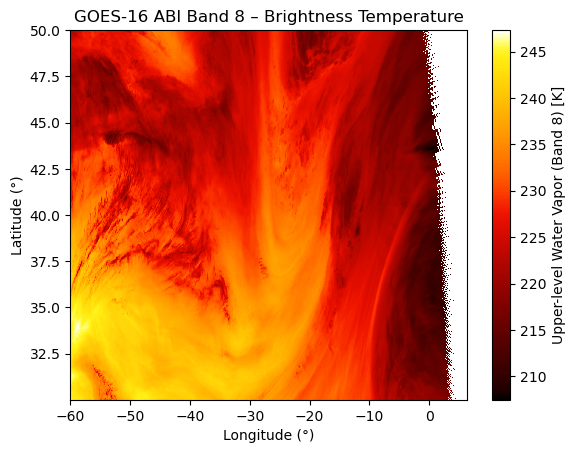

CPU times: user 2.18 s, sys: 92 ms, total: 2.27 s
Wall time: 1.57 s


In [57]:
%%time
# Assign the plot result to a variable
img = subset.CMI_C08.plot(x='lon', y='lat', cmap=cc.m_fire)

# Then set axis labels, colorbar label, and title
plt.xlabel("Longitude (°)")
plt.ylabel("Latitude (°)")
img.colorbar.set_label('Upper-level Water Vapor (Band 8) [K]')
plt.title('GOES-16 ABI Band 8 – Brightness Temperature')
plt.show()

## Using the built functions
### Loading Data
The following code opens the config file, turns it into a dataset using the GoesData Dataset model, then normalizes the data to be between [-1, 1].
Normalizing the data is important in order to ensure that the gradients do not get to high or get too low. If the gradient got too high or too low, then when doing gradient descent and computing the loss, it makes the weights too large or too small.

In [58]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)
dataset =  GoesData(config)
dataset.normalize()

The config file looks as follows:
```yaml
model:
  name: FINER
  in_features: 2          # lat, lon       # predicted GOES value
  hidden_features: 256
  hidden_layers: 2
  first_omega_0: 30.0
  hidden_omega_0: 30.0
  first_k: .6
  hidden_k: .6
  bias: true
  first_bias_scale: null
  scale_req_grad: false
  
data:
    file_addr: /notebook_dir/public/mickellals-public/goes-16-2003-10-weeks.tmp.zarr
    normalize: true
    bands: ["CMI_C07", "CMI_C08", "CMI_C10"]
    lat_min: 35
    lat_max: 45
    lon_min: -100
    lon_max: -75
    time_slice: 0
    
train:
    batch_size: 256
    epochs: 1000
```

For loading the data, the data portion of the config file is used. The ```load_data``` function under ```utils/utils.py``` selects the patch of time used based on the config file from the data portion. The parameters in the data section do the following:
- ```file_addr```: where the data is stored
- ```normalize```: whether or not the data should be normalized to be between [-1, 1]
- ```bands```: which bands should be included in the compression
- ```lat_min```: the minimum latitude to use (smallest is -90)
- ```lat_max```: the maximum latitude value to use use (largest is 90)
- ```lon_min```: the minimum longitude value (smallest is 0)
- ```lon_max```: the maximum longitude value (largest is 360)
- ```time_slice```: It picks which index in the list to use for time. 

The function GoesData(config) uses the following functions:
```python
def load_data(config_file):
    """
    Loads the data based on the information from the config file (should be .yaml file).
    It then filters the data based on the yaml file
    config_file: the file which stores the configuration settings for the data
    """
    file_path = config_file['data']['file_addr']
    data = xr.open_zarr(file_path)
    data = data.assign_coords(lon=((data.lon + 180) % 360 - 180))
    
    bands = config_file['data']['bands']
    lat_min = config_file['data']['lat_min']
    lat_max = config_file['data']['lat_max']
    lon_min = config_file['data']['lon_min']
    lon_max = config_file['data']['lon_max']
    time_slice = config_file['data']['time_slice']
    
    data_subset = data[bands]
    data_subset = data_subset.isel(t=time_slice).sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
    
    return data_subset  
```
The load data function takes the config file and returns the dataset within the criteria.

The other main function is ```xarray_to_tensor``` 

```python
def xarray_to_tensor(config_file):
    """
    Converts the xarray from the config file to a tensor mapping latitude and longitude to the band values.
    Removes the NaN values
    Args:
        config_file: The yaml file that has the information 
    """
    dataset = load_data(config_file)

    bands = config_file['data']['bands']
    lat = dataset.lat.values
    lon = dataset.lon.values

    tensor = create_tensor_from_dataset(dataset, bands)
    coords = create_coords(lat, lon)

    coords, tensor = filter_valid(coords, tensor)

    return coords, tensor
```

This function uses the load_data function to create an xarray. After creating the xarray, it creates a tensor by creating a tensor of size (latxlon, num bands) which contains the value for each band and by turning the coordinates into a tensor. It then filters out all the tensor values with a NaN value. For more information, view ```utils/utils.py```

### Creating the model
The following code gets the model configuration settings from the yaml file and displays each of the configuration set.
- ```'name' 'FINER' ```: this just displays the name of the model. It is not important for this tutorial. It is meant for future use where someone can select different models
- ```'in_features': 2```: This refers to the number of inputsfeatures to this model. In this tutorial, there are only two inputs features(latitude and longitude). Time is not being used because if it were, it would make training a lot larger. If we were to train on the whole dataset, it would have to process 1680x8133x8130 (time x latitude x longitude). In order to reduce the training time for this example it will only consider latitude and longitude.
- ```'hidden_features: 256'```: This is refers to the number of features each hidden layer outputs. Since it is 256, this means that there each hidden layer outputs 256 features learned from the data. 
- ```hidden_layers: 2```: This refers to the number of layers other than the input and output layer. Since there are 2 hidden layers this means that the model architecture has 2 layers that the data passes through. Each hidden layer has 256 features.
- ```first_omega_0: 30.0```: This is one of the hyperparameters of the model, specifically used in the first layer of the network. This omega_0 value scales the input to the sine activation function used in SIREN and FINER models, effectively controlling the frequency of the learned signal. A higher value of omega_0 allows the network to model higher-frequency (more detailed, rapidly changing) patterns in the data. In this case, setting first_omega_0 to 30.0 means the first layer will produce high-frequency features, enabling the model to capture fine-scale variations in the input.
- ```hidden_omega_0: 30.0```: This hyperparameter controls the frequency scaling in the hidden layers of the model. Like first_omega_0, it scales the input to the sine activation function, determining how oscillatory or smooth the layer outputs are. A higher hidden_omega_0 value allows the network to maintain or introduce high-frequency components deeper in the network, enabling it to represent complex, fine-grained structures. Setting hidden_omega_0 to 30.0 keeps the model highly expressive throughout its hidden layers, preserving the ability to learn detailed variations beyond the input layer.
- ```bias: True``` : This specifies whether the linear layers include a bias term (y = Wx + b): When True, each linear layer will include and learn a bias vector b, allowing the network to shift the output independently of the input. In FINER, bias is typically required because some of the sine-based activations or initializations depend on it. You must set this to True for FINER to function as designed.
- ```first_bias_scale: None```: This is an optional hyperparameter used to scale the bias in the first layer, usually during initialization.If None, the model will fall back to a default scaling (if defined in the initializer). If a float value is provided (e.g., first_bias_scale: 0.5), it would be used to scale the magnitude of the bias in the first layer, potentially controlling how much shift the layer can introduce. 
- ```out_features: 3```: This refers to the number of features it should output (the number of bands). Since it takes a latitude and longitude in the example and outputs an image for each band there are 3 output features since there are 3 bands used. 


In [59]:
model_params = config["model"]
model_params["out_features"] = len(config["data"]["bands"])
model_params

{'name': 'FINER',
 'in_features': 2,
 'hidden_features': 256,
 'hidden_layers': 2,
 'first_omega_0': 30.0,
 'hidden_omega_0': 30.0,
 'first_k': 0.6,
 'hidden_k': 0.6,
 'bias': True,
 'first_bias_scale': None,
 'scale_req_grad': False,
 'out_features': 1}

The following code takes the model section from the config file. It then uses it to create the model. The number of out_features is dependent on the number of bands, which is why it is created separately.
For the line ```criterion = nn.MSELoss()```, this means mean squared this creates the loss $l_n = (x_n - y_n)^2$ for each element $x$ and $y$. It takes the average of each loss so it looks like $L = \frac{1}{N} \sum_{n=1}^N(x_n - y_n)^2$. The neural network is trying to minimize this function.

For ```torch.optim.Adam(model.parameters(), lr=1e-4)```, Adam is an optimization algorithm. Once you define your model, you need a way to update its parameters (weights and biases) based on the loss — this is where an optimizer comes in. PyTorch provides several optimizers, and one of the most commonly used is Adam. This line sets up the optimizer that will adjust the model's weights during training, using a smart strategy that adapts over time for better performance. The paper for Adam can be found [here](https://arxiv.org/pdf/1412.6980).

The line ```device = torch.device("cuda" if torch.cuda.is_available() else "cpu")``` checks to see i a CUDA-compatible GPU is available on your machine. If it is, PyTorch will use it to run your model, otherwise it will default to the CPU. GPUs are specifically designed for parallel processing, which allows them to handle the large matrix and tensor operations that are common in deep learning much more efficiently than CPUs. This can significantly speed up training and inference.

For ```psnr_fn = lambda pred, target: peak_signal_noise_ratio(pred, target, data_range=2.0)```, PSNR is used to measure the reconstruction quality of an image — higher PSNR means better quality (closer to the original). This line sets up a quick function to measure how close the model's output image is to the original image using a PSNR. To read the wiki for PSNR, [click here](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)

```model = model.to(device)```:  This line moves the model’s parameters (weights, biases, etc.) to the computing device selected — either a GPU (if available) or a CPU.

In [60]:
model = FinerModel(in_features=model_params["in_features"], out_features=model_params["out_features"], hidden_layers=model_params["hidden_layers"], 
                   hidden_features=model_params["hidden_features"], first_omega_0=model_params["first_omega_0"], 
                   hidden_omega_0=model_params["hidden_omega_0"], first_k=model_params["first_k"], hidden_k=model_params["hidden_k"], 
                   bias=model_params["bias"])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
psnr_fn = lambda pred, target: peak_signal_noise_ratio(pred, target, data_range=2.0)
model = model.to(device)


The [DataLoader](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html) class gives you more control over the data. It allows you to put your data into batches and returns a batch of train features and training labels 

In [61]:
loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True)

### Training the Model
The training function uses the function ```train_batches_model_with_psnr``` found in ```train.py```.
```python
def train_batches_model_with_psnr(
    model,
    optimizer,
    criterion,
    data_loader,          
    psnr_fn,
    n_epochs=500,
    log_interval=50,
    zero_mean=True,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    best_loss = float('inf')
    best_model_state = None
    loss_history = []
    psnr_history = []

    model.to(device)

    for epoch in range(1, n_epochs + 1):
        model.train()
        epoch_loss = 0.0

        for coords_batch, gt_batch in data_loader:
            coords_batch = coords_batch.float().to(device)
            gt_batch = gt_batch.float().to(device)

            optimizer.zero_grad()
            pred = model(coords_batch)
            loss = criterion(pred, gt_batch)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * coords_batch.size(0)  # Weighted by batch size

        avg_loss = epoch_loss / len(data_loader.dataset)
        loss_history.append(avg_loss)

        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = model.state_dict()

        # Logging
        if epoch % log_interval == 0:
            model.eval()
            with torch.no_grad():
                # Full dataset PSNR (optional: use DataLoader again to do this in chunks)
                all_preds = []
                all_targets = []

                for coords_batch, gt_batch in data_loader:
                    coords_batch = coords_batch.float().to(device)
                    gt_batch = gt_batch.float().to(device)
                    preds = model(coords_batch)

                    if zero_mean:
                        preds = preds / 2 + 0.5
                        gt_batch = gt_batch / 2 + 0.5

                    all_preds.append(preds.cpu())
                    all_targets.append(gt_batch.cpu())

                pred_eval = torch.cat(all_preds, dim=0)
                gt_eval = torch.cat(all_targets, dim=0)
                psnr = psnr_fn(pred_eval, gt_eval).item()
                psnr_history.append((epoch, psnr))

            print(f"Epoch {epoch:03d} — Loss: {avg_loss:.6f} — PSNR: {psnr:.4f}")

    model.load_state_dict(best_model_state)
    return model, loss_history, psnr_history
```
The code loops through ```n_epoch``` times. Within each epoch, it runs batches for whatever size was set earlier. Each epoch trains on all the data. For each batch, it computes the loss and changes the weights to minimize the loss. For compressing the data, it is generally better to train on the whole image instead of batches. This is because you want it to learn all the features of the image at once. One reason is because it allows the model to learn long-range dependencies, which is crucial for better compression.
After each epoch, it saves the weights that reduces the loss the most. After every ```log_interval```, it calculates the psnr which also shows how effective it is.

Note: For 5 epochs, it had taken me around 1 minute and 30 seconds, but it can be longer

In [62]:
%%time
trained_model, losses, psnrs = train_batches_model_with_psnr(
    model, optimizer, criterion, loader, psnr_fn, n_epochs = 5, log_interval = 1
)

/opt/conda/envs/marble/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(


Epoch 001 — Loss: 0.264742 — PSNR: 18.4970
Epoch 002 — Loss: 0.226163 — PSNR: 19.1172
Epoch 003 — Loss: 0.196063 — PSNR: 19.6594
Epoch 004 — Loss: 0.173055 — PSNR: 20.1373
Epoch 005 — Loss: 0.155021 — PSNR: 20.5787
CPU times: user 11min 2s, sys: 6min 57s, total: 18min
Wall time: 1min 29s


The code below saves all the information from the GoesData model and stores it in a pth file. It is important to save the data, since the data can be lost if you close the notebook.
- ```model_state_dict```: This saves all the learnable parameters (weights and biases).
- ```coords```: Refers to the latitude and longitude values used for training. It is the input of the model.
- ```coords_min```, ```coords_max```: When saving the coordinates, the normalized version is saved. Saving ```coords_min``` and ```coords_max``` allows you to denormalize the data.
- ```gt```: Refers to the ground truth. This is the actual band values for each latitude and longitude value that the data has compressed.
- ```tensor_min```, ```tensor_max```:  Like the ```coords``` values, this is saved to denormalize the data.
- ```loss_history```: This is a list of the losses after each epoch. It is stored in case the loss wants to be checked after each epoch.
- ```psnr_history```: This is a list of the psnr after every ```log_interval``` epochs. Used to see how it changes over time.

In [63]:
checkpoint = {
    'model_state_dict': trained_model.state_dict(),
    'coords': dataset.coords,
    'coords_min': dataset.coords_min,
    'coords_max': dataset.coords_max,
    'gt': dataset.tensor,
    'tensor_min': dataset.tensor_min,
    'tensor_max': dataset.tensor_max,
    'loss_history': losses,
    'psnr_history': psnrs,
}

torch.save(checkpoint, 'goes_model_coords_tutorial.pth')

To run the model, you can run the following code:

In [64]:
with torch.no_grad():
    predictions = model(dataset.coords)
    loss = criterion(predictions, dataset.tensor)
    print(f"Loss on training data: {loss.item():.6f}")

Loss on training data: 0.140041


If you wanted to load the data from the file ```goes_model_coords_tutorial.pth```, you would first recreate the model as shown above by using the config file ```config.yaml```
```python
model_params = config["model"]
model = FinerModel(in_features=model_params["in_features"], out_features=model_params["out_features"], hidden_layers=model_params["hidden_layers"], 
                   hidden_features=model_params["hidden_features"], first_omega_0=model_params["first_omega_0"], 
                   hidden_omega_0=model_params["hidden_omega_0"], first_k=model_params["first_k"], hidden_k=model_params["hidden_k"], 
                   bias=model_params["bias"])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
psnr_fn = lambda pred, target: peak_signal_noise_ratio(pred, target, data_range=2.0)
model = model.to(device)
```
After you can load the model with the following code
```python
checkpoint = torch.load("goes_model_coords_tutorial.pth")
model.load_state_dict(checkpoint['model_state_dict'])
```
Assuming you will only load the model to test it, set the model to evaluation
```python
model.eval()
```

To denormalize the tensor, you can use the ```denormalize_tensor``` function found in ```utils.py```. The ```GoesData``` class also has a denormalize function in case the normalized tensor needs to be denormalized.

In [65]:
predictions_denorm = denormalize_tensor(predictions, dataset.tensor_min.to(device), dataset.tensor_max.to(device))

It is better to move the tensor to the cpu since the GPU's memory is limited. There is no real significant performance gain by leaving the data on the GPU. 

In [66]:
tensor = dataset.tensor.cpu().numpy()
predictions_denorm = predictions_denorm.cpu().numpy()
coords = dataset.coords.cpu().numpy()
tensor_denorm = denormalize_tensor(
    dataset.tensor, 
    checkpoint['tensor_min'].to(device), 
    checkpoint['tensor_max'].to(device)
).cpu().numpy()

The plot_band_comparison function can be found in ```utils.py```. It is used to plot both the original and tensor. If the output does not look like the input, then it can be improved by running the model longer. This is because when doing gradient descent, it only makes small improvements over many steps. The only downside is that you have to wait longer as the training would take more time.

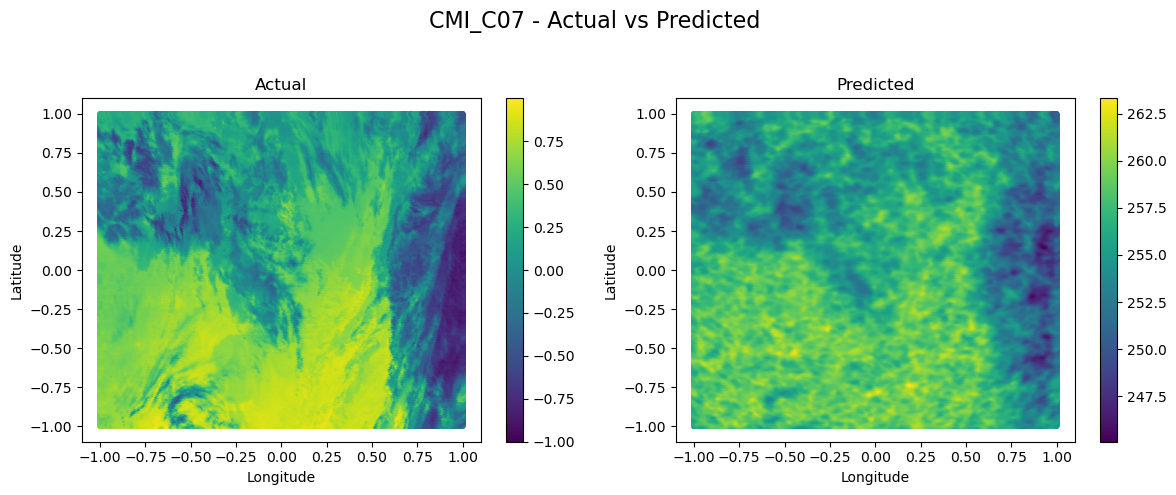

CPU times: user 11.5 s, sys: 11.7 ms, total: 11.5 s
Wall time: 11.5 s


In [67]:
%%time
plot_band_comparison(tensor, predictions_denorm, coords, band_index=0, band_name="CMI_C07")

GT min/max: -1.0 / 0.9999999997065108
Pred min/max: 245.09143785777601 / 263.30852258364183


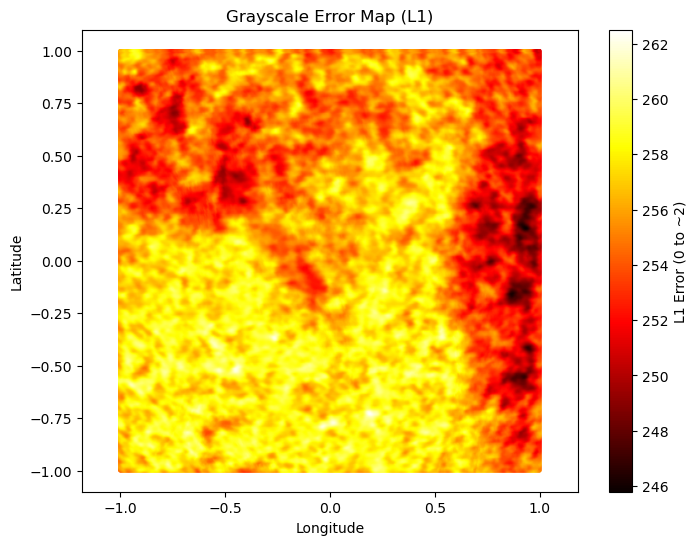

CPU times: user 5.19 s, sys: 135 ms, total: 5.33 s
Wall time: 5.2 s


In [68]:
%%time
print(f"GT min/max: {tensor.min()} / {tensor.max()}")
print(f"Pred min/max: {predictions_denorm.min()} / {predictions_denorm.max()}")
error_map_gray = np.mean(np.abs(tensor - predictions_denorm), axis=-1)  # shape: (N,)

plt.figure(figsize=(8, 6))
sc = plt.scatter(coords[:, 1], coords[:, 0], c=error_map_gray, cmap='hot', s=2)
plt.colorbar(sc, label="L1 Error (0 to ~2)")
plt.title("Grayscale Error Map (L1)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis('equal')
plt.show()

The loss and psnr history can be viewed from the checkpoint at anytime. It can also be viewed using the variables after running the training. 

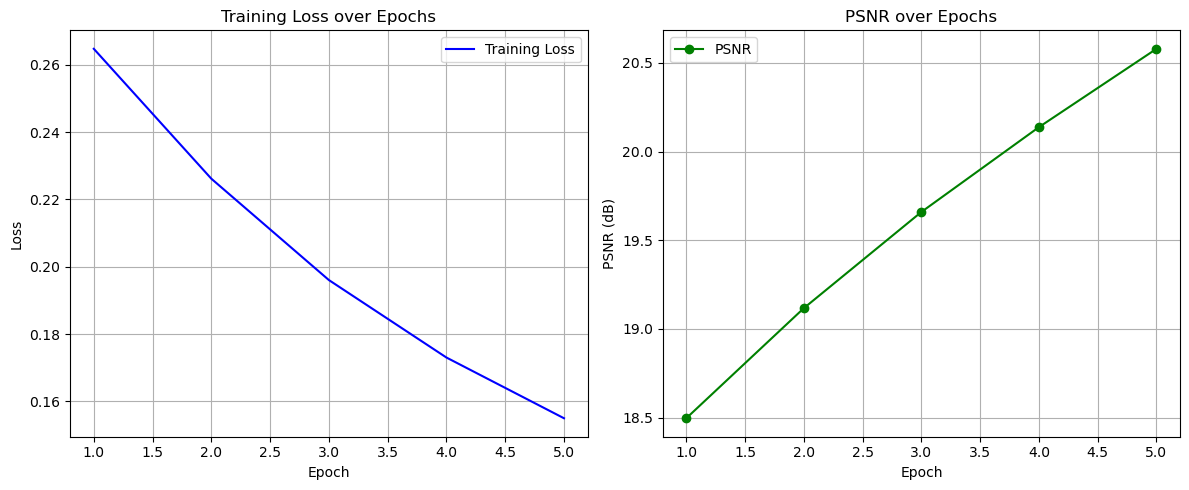

CPU times: user 323 ms, sys: 8.48 ms, total: 332 ms
Wall time: 326 ms


In [69]:
%%time
# Unpack PSNR history into separate lists
psnr_history = checkpoint['psnr_history']
loss_history = checkpoint['loss_history']
psnr_epochs, psnr_values = zip(*psnr_history)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_history) + 1), loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.legend()

# Plot PSNR
plt.subplot(1, 2, 2)
plt.plot(psnr_epochs, psnr_values, label='PSNR', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('PSNR over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

The training loss is still decreasing and the PSNR is still increasing as the number of epochs increase. Since it hasn't flattened and the goal is to overfit the model for data compression, then this means the image produced would look more similar the more epochs it is run for. 